In [4]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.models import Model
from keras import callbacks, optimizers
from sklearn.preprocessing import MinMaxScaler
import tqdm
%matplotlib inline

import tensorflow as tf

Esse modelo nao foi usado

In [5]:
data = pd.read_csv('../Files tcc/data.csv')
data.head()

,Data,Fechamento
0,01-01-2015,314.25
1,02-01-2015,315.03
2,03-01-2015,281.08
3,04-01-2015,264.20
4,05-01-2015,274.47


In [6]:
df = data[['Fechamento']]
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([[  314.25],
       [  315.03],
       [  281.08],
       ...,
       [10623.54],
       [10594.49],
       [10575.53]], dtype=float32)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [8]:
train_size = int(len(dataset)*0.67)
teste_size = len(dataset) - train_size
train,test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]
print(len(train), len(test))
train

1145 564


array([[0.00704736],
       [0.00708773],
       [0.00533042],
       ...,
       [0.5205054 ],
       [0.5659936 ],
       [0.5369604 ]], dtype=float32)

In [9]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [10]:
look_back=1
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test,look_back=look_back)
print(len(trainX),len(trainY),len(testX),len(testY))

1143 1143 562 562


In [11]:
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

In [12]:
def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))

In [13]:
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

In [14]:
class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tf.distributions.Normal(mu, sigma)
        return self.kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))


In [15]:
batch_size = 1
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(1, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [16]:
def neg_log_likelihood(y_obs, y_pred, sigma=1.0):
    dist = tf.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(trainX, trainY, batch_size=562, epochs=1500, verbose=1);


Epoch 1/1500
1143/1143 [==============================] - 1s 658us/step - loss: 1125.9006 - mse: 2.3259
Epoch 2/1500
1143/1143 [==============================] - 0s 10us/step - loss: 2882.1780 - mse: 8.4725
Epoch 3/1500
1143/1143 [==============================] - 0s 9us/step - loss: 1168.6469 - mse: 2.3642
Epoch 4/1500
1143/1143 [==============================] - 0s 10us/step - loss: 5104.8116 - mse: 16.4065
Epoch 5/1500
1143/1143 [==============================] - 0s 8us/step - loss: 1098.0206 - mse: 3.9526
Epoch 6/1500
1143/1143 [==============================] - 0s 8us/step - loss: 38223.5374 - mse: 134.4955
Epoch 7/1500
1143/1143 [==============================] - 0s 9us/step - loss: 2775.4224 - mse: 8.2516
Epoch 8/1500
1143/1143 [==============================] - 0s 10us/step - loss: 11035.6782 - mse: 37.6234
Epoch 9/1500
1143/1143 [==============================] - 0s 10us/step - loss: 6465.9360 - mse: 21.2722
Epoch 10/1500
1143/1143 [==============================] - 0s 8us/st

1143/1143 [==============================] - 0s 10us/step - loss: 612.8774 - mse: 0.3812
Epoch 79/1500
1143/1143 [==============================] - 0s 10us/step - loss: 561.1731 - mse: 0.2040
Epoch 80/1500
1143/1143 [==============================] - 0s 9us/step - loss: 711.6039 - mse: 0.7356
Epoch 81/1500
1143/1143 [==============================] - 0s 7us/step - loss: 674.8093 - mse: 0.6070
Epoch 82/1500
1143/1143 [==============================] - 0s 9us/step - loss: 1125.7954 - mse: 2.2223
Epoch 83/1500
1143/1143 [==============================] - 0s 9us/step - loss: 622.7200 - mse: 0.4530
Epoch 84/1500
1143/1143 [==============================] - 0s 7us/step - loss: 548.6700 - mse: 0.1478
Epoch 85/1500
1143/1143 [==============================] - 0s 7us/step - loss: 767.6794 - mse: 0.9272
Epoch 86/1500
1143/1143 [==============================] - 0s 8us/step - loss: 738.8798 - mse: 0.8224
Epoch 87/1500
1143/1143 [==============================] - 0s 8us/step - loss: 875.3119 - mse

1143/1143 [==============================] - 0s 8us/step - loss: 526.8034 - mse: 0.0706
Epoch 158/1500
1143/1143 [==============================] - 0s 9us/step - loss: 537.2392 - mse: 0.1044
Epoch 159/1500
1143/1143 [==============================] - 0s 8us/step - loss: 592.8013 - mse: 0.3097
Epoch 160/1500
1143/1143 [==============================] - 0s 8us/step - loss: 527.2506 - mse: 0.0712
Epoch 161/1500
1143/1143 [==============================] - 0s 8us/step - loss: 550.0065 - mse: 0.1516
Epoch 162/1500
1143/1143 [==============================] - 0s 10us/step - loss: 1187.3606 - mse: 2.4207
Epoch 163/1500
1143/1143 [==============================] - 0s 10us/step - loss: 519.5791 - mse: 0.0405
Epoch 164/1500
1143/1143 [==============================] - 0s 10us/step - loss: 574.2093 - mse: 0.2377
Epoch 165/1500
1143/1143 [==============================] - 0s 8us/step - loss: 524.9913 - mse: 0.0597
Epoch 166/1500
1143/1143 [==============================] - 0s 8us/step - loss: 527.

1143/1143 [==============================] - 0s 10us/step - loss: 520.9028 - mse: 0.0457
Epoch 237/1500
1143/1143 [==============================] - 0s 8us/step - loss: 520.8343 - mse: 0.0471
Epoch 238/1500
1143/1143 [==============================] - 0s 9us/step - loss: 516.5205 - mse: 0.0295
Epoch 239/1500
1143/1143 [==============================] - 0s 10us/step - loss: 549.8846 - mse: 0.1496
Epoch 240/1500
1143/1143 [==============================] - 0s 10us/step - loss: 528.9047 - mse: 0.0751
Epoch 241/1500
1143/1143 [==============================] - 0s 8us/step - loss: 520.4043 - mse: 0.0447
Epoch 242/1500
1143/1143 [==============================] - 0s 9us/step - loss: 523.0821 - mse: 0.0530
Epoch 243/1500
1143/1143 [==============================] - 0s 10us/step - loss: 544.8439 - mse: 0.1311
Epoch 244/1500
1143/1143 [==============================] - 0s 9us/step - loss: 522.7460 - mse: 0.0531
Epoch 245/1500
1143/1143 [==============================] - 0s 8us/step - loss: 519.

1143/1143 [==============================] - 0s 10us/step - loss: 518.9009 - mse: 0.0421
Epoch 315/1500
1143/1143 [==============================] - 0s 8us/step - loss: 529.4339 - mse: 0.0813
Epoch 316/1500
1143/1143 [==============================] - 0s 8us/step - loss: 523.0669 - mse: 0.0527
Epoch 317/1500
1143/1143 [==============================] - 0s 8us/step - loss: 529.7177 - mse: 0.0767
Epoch 318/1500
1143/1143 [==============================] - 0s 11us/step - loss: 516.2004 - mse: 0.0284
Epoch 319/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.6902 - mse: 0.0374
Epoch 320/1500
1143/1143 [==============================] - 0s 9us/step - loss: 554.2631 - mse: 0.1649
Epoch 321/1500
1143/1143 [==============================] - 0s 8us/step - loss: 530.3657 - mse: 0.0799
Epoch 322/1500
1143/1143 [==============================] - 0s 8us/step - loss: 525.5634 - mse: 0.0620
Epoch 323/1500
1143/1143 [==============================] - 0s 8us/step - loss: 519.8

1143/1143 [==============================] - 0s 8us/step - loss: 518.4989 - mse: 0.0366
Epoch 394/1500
1143/1143 [==============================] - 0s 8us/step - loss: 556.7894 - mse: 0.1737
Epoch 395/1500
1143/1143 [==============================] - 0s 9us/step - loss: 534.9370 - mse: 0.0960
Epoch 396/1500
1143/1143 [==============================] - ETA: 0s - loss: 527.7573 - mse: 0.039 - 0s 10us/step - loss: 520.0861 - mse: 0.0428
Epoch 397/1500
1143/1143 [==============================] - 0s 10us/step - loss: 564.0282 - mse: 0.1989
Epoch 398/1500
1143/1143 [==============================] - 0s 7us/step - loss: 524.7918 - mse: 0.0597
Epoch 399/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.3132 - mse: 0.0359
Epoch 400/1500
1143/1143 [==============================] - 0s 10us/step - loss: 523.9154 - mse: 0.0561
Epoch 401/1500
1143/1143 [==============================] - 0s 9us/step - loss: 531.7034 - mse: 0.0843
Epoch 402/1500
1143/1143 [===================

Epoch 472/1500
1143/1143 [==============================] - 0s 9us/step - loss: 523.7585 - mse: 0.0552
Epoch 473/1500
1143/1143 [==============================] - 0s 9us/step - loss: 519.1765 - mse: 0.0409
Epoch 474/1500
1143/1143 [==============================] - 0s 10us/step - loss: 520.5691 - mse: 0.0442
Epoch 475/1500
1143/1143 [==============================] - 0s 9us/step - loss: 522.9729 - mse: 0.0538
Epoch 476/1500
1143/1143 [==============================] - 0s 7us/step - loss: 519.6224 - mse: 0.0406
Epoch 477/1500
1143/1143 [==============================] - 0s 9us/step - loss: 520.9738 - mse: 0.0457
Epoch 478/1500
1143/1143 [==============================] - 0s 9us/step - loss: 540.9028 - mse: 0.1163
Epoch 479/1500
1143/1143 [==============================] - 0s 10us/step - loss: 531.6127 - mse: 0.0834
Epoch 480/1500
1143/1143 [==============================] - 0s 10us/step - loss: 522.1065 - mse: 0.0497
Epoch 481/1500
1143/1143 [==============================] - 0s 9us/ste

1143/1143 [==============================] - 0s 10us/step - loss: 518.0294 - mse: 0.0351
Epoch 551/1500
1143/1143 [==============================] - 0s 9us/step - loss: 521.4100 - mse: 0.0476
Epoch 552/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.0779 - mse: 0.0358
Epoch 553/1500
1143/1143 [==============================] - 0s 7us/step - loss: 521.5066 - mse: 0.0475
Epoch 554/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.4331 - mse: 0.0342
Epoch 555/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.3802 - mse: 0.0335
Epoch 556/1500
1143/1143 [==============================] - 0s 11us/step - loss: 518.1282 - mse: 0.0359
Epoch 557/1500
1143/1143 [==============================] - 0s 12us/step - loss: 520.2107 - mse: 0.0427
Epoch 558/1500
1143/1143 [==============================] - 0s 12us/step - loss: 527.4617 - mse: 0.0757
Epoch 559/1500
1143/1143 [==============================] - 0s 10us/step - loss: 55

1143/1143 [==============================] - 0s 10us/step - loss: 518.6134 - mse: 0.0376
Epoch 629/1500
1143/1143 [==============================] - 0s 8us/step - loss: 523.3377 - mse: 0.0539
Epoch 630/1500
1143/1143 [==============================] - 0s 9us/step - loss: 521.3471 - mse: 0.0467
Epoch 631/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.8769 - mse: 0.0348
Epoch 632/1500
1143/1143 [==============================] - 0s 10us/step - loss: 520.0423 - mse: 0.0423
Epoch 633/1500
1143/1143 [==============================] - 0s 7us/step - loss: 520.9363 - mse: 0.0452
Epoch 634/1500
1143/1143 [==============================] - 0s 8us/step - loss: 519.3822 - mse: 0.0399
Epoch 635/1500
1143/1143 [==============================] - 0s 9us/step - loss: 516.2199 - mse: 0.0287
Epoch 636/1500
1143/1143 [==============================] - 0s 10us/step - loss: 519.1995 - mse: 0.0397
Epoch 637/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.9

1143/1143 [==============================] - 0s 9us/step - loss: 517.2447 - mse: 0.0320
Epoch 707/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.5613 - mse: 0.0336
Epoch 708/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.3672 - mse: 0.0359
Epoch 709/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.8596 - mse: 0.0379
Epoch 710/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.0544 - mse: 0.0353
Epoch 711/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.4819 - mse: 0.0334
Epoch 712/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.6786 - mse: 0.0377
Epoch 713/1500
1143/1143 [==============================] - 0s 9us/step - loss: 523.3080 - mse: 0.0543
Epoch 714/1500
1143/1143 [==============================] - 0s 10us/step - loss: 520.7934 - mse: 0.0446
Epoch 715/1500
1143/1143 [==============================] - 0s 8us/step - loss: 519.

1143/1143 [==============================] - 0s 9us/step - loss: 519.5693 - mse: 0.0401
Epoch 786/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.6087 - mse: 0.0345
Epoch 787/1500
1143/1143 [==============================] - 0s 9us/step - loss: 523.9003 - mse: 0.0556
Epoch 788/1500
1143/1143 [==============================] - 0s 11us/step - loss: 517.9643 - mse: 0.0345
Epoch 789/1500
1143/1143 [==============================] - 0s 12us/step - loss: 520.2978 - mse: 0.0440
Epoch 790/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.1476 - mse: 0.0362
Epoch 791/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.9132 - mse: 0.0380
Epoch 792/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.4391 - mse: 0.0370
Epoch 793/1500
1143/1143 [==============================] - 0s 8us/step - loss: 519.0550 - mse: 0.0389
Epoch 794/1500
1143/1143 [==============================] - 0s 10us/step - loss: 519

1143/1143 [==============================] - 0s 10us/step - loss: 516.9425 - mse: 0.0311
Epoch 865/1500
1143/1143 [==============================] - 0s 10us/step - loss: 519.1794 - mse: 0.0394
Epoch 866/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.8452 - mse: 0.0379
Epoch 867/1500
1143/1143 [==============================] - 0s 8us/step - loss: 524.7684 - mse: 0.0592
Epoch 868/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.9909 - mse: 0.0383
Epoch 869/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.7233 - mse: 0.0340
Epoch 870/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.6168 - mse: 0.0368
Epoch 871/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.3296 - mse: 0.0358
Epoch 872/1500
1143/1143 [==============================] - 0s 9us/step - loss: 516.2436 - mse: 0.0287
Epoch 873/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.

1143/1143 [==============================] - 0s 7us/step - loss: 517.6874 - mse: 0.0337
Epoch 944/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.1744 - mse: 0.0352
Epoch 945/1500
1143/1143 [==============================] - 0s 9us/step - loss: 523.3568 - mse: 0.0541
Epoch 946/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.9997 - mse: 0.0393
Epoch 947/1500
1143/1143 [==============================] - 0s 9us/step - loss: 519.1940 - mse: 0.0390
Epoch 948/1500
1143/1143 [==============================] - 0s 7us/step - loss: 519.4027 - mse: 0.0407
Epoch 949/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.7624 - mse: 0.0345
Epoch 950/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.7919 - mse: 0.0376
Epoch 951/1500
1143/1143 [==============================] - 0s 9us/step - loss: 519.2824 - mse: 0.0394
Epoch 952/1500
1143/1143 [==============================] - 0s 7us/step - loss: 518.874

1143/1143 [==============================] - 0s 9us/step - loss: 517.8672 - mse: 0.0344
Epoch 1023/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.5477 - mse: 0.0337
Epoch 1024/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.8158 - mse: 0.0378
Epoch 1025/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.6634 - mse: 0.0338
Epoch 1026/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.3851 - mse: 0.0364
Epoch 1027/1500
1143/1143 [==============================] - 0s 7us/step - loss: 517.5108 - mse: 0.0335
Epoch 1028/1500
1143/1143 [==============================] - 0s 7us/step - loss: 519.1960 - mse: 0.0392
Epoch 1029/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.8804 - mse: 0.0346
Epoch 1030/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.0178 - mse: 0.0354
Epoch 1031/1500
1143/1143 [==============================] - 0s 11us/step - l

1143/1143 [==============================] - 0s 8us/step - loss: 518.5207 - mse: 0.0367
Epoch 1101/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.8902 - mse: 0.0348
Epoch 1102/1500
1143/1143 [==============================] - 0s 10us/step - loss: 519.0588 - mse: 0.0384
Epoch 1103/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.5248 - mse: 0.0335
Epoch 1104/1500
1143/1143 [==============================] - 0s 7us/step - loss: 518.0745 - mse: 0.0349
Epoch 1105/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.5720 - mse: 0.0331
Epoch 1106/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.1896 - mse: 0.0352
Epoch 1107/1500
1143/1143 [==============================] - 0s 7us/step - loss: 517.8906 - mse: 0.0346
Epoch 1108/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.4430 - mse: 0.0338
Epoch 1109/1500
1143/1143 [==============================] - 0s 8us/step - loss

1143/1143 [==============================] - 0s 10us/step - loss: 517.5780 - mse: 0.0329
Epoch 1179/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.5205 - mse: 0.0337
Epoch 1180/1500
1143/1143 [==============================] - 0s 7us/step - loss: 519.6392 - mse: 0.0408
Epoch 1181/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.7526 - mse: 0.0337
Epoch 1182/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.6509 - mse: 0.0334
Epoch 1183/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.0141 - mse: 0.0351
Epoch 1184/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.7860 - mse: 0.0353
Epoch 1185/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.6030 - mse: 0.0340
Epoch 1186/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.7111 - mse: 0.0338
Epoch 1187/1500
1143/1143 [==============================] - 0s 10us/step - l

1143/1143 [==============================] - 0s 9us/step - loss: 517.8750 - mse: 0.0342
Epoch 1256/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.5091 - mse: 0.0329
Epoch 1257/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.9902 - mse: 0.0356
Epoch 1258/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.4641 - mse: 0.0331
Epoch 1259/1500
1143/1143 [==============================] - 0s 8us/step - loss: 523.8807 - mse: 0.0560
Epoch 1260/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.5748 - mse: 0.0338
Epoch 1261/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.0462 - mse: 0.0347
Epoch 1262/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.3814 - mse: 0.0330
Epoch 1263/1500
1143/1143 [==============================] - 0s 7us/step - loss: 518.1629 - mse: 0.0352
Epoch 1264/1500
1143/1143 [==============================] - 0s 8us/step - los

1143/1143 [==============================] - 0s 7us/step - loss: 518.4666 - mse: 0.0366
Epoch 1334/1500
1143/1143 [==============================] - 0s 7us/step - loss: 517.4842 - mse: 0.0330
Epoch 1335/1500
1143/1143 [==============================] - 0s 9us/step - loss: 518.2372 - mse: 0.0362
Epoch 1336/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.1219 - mse: 0.0351
Epoch 1337/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.5298 - mse: 0.0332
Epoch 1338/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.4994 - mse: 0.0331
Epoch 1339/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.5299 - mse: 0.0329
Epoch 1340/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.3713 - mse: 0.0334
Epoch 1341/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.0192 - mse: 0.0347
Epoch 1342/1500
1143/1143 [==============================] - 0s 8us/step - l

1143/1143 [==============================] - 0s 10us/step - loss: 521.3251 - mse: 0.0463
Epoch 1412/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.6066 - mse: 0.0338
Epoch 1413/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.6728 - mse: 0.0335
Epoch 1414/1500
1143/1143 [==============================] - 0s 11us/step - loss: 517.6101 - mse: 0.0340
Epoch 1415/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.6647 - mse: 0.0341
Epoch 1416/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.5340 - mse: 0.0366
Epoch 1417/1500
1143/1143 [==============================] - 0s 7us/step - loss: 518.1291 - mse: 0.0353
Epoch 1418/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.1853 - mse: 0.0363
Epoch 1419/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.5611 - mse: 0.0337
Epoch 1420/1500
1143/1143 [==============================] - 0s 10us/step

1143/1143 [==============================] - 0s 10us/step - loss: 517.7959 - mse: 0.0341
Epoch 1490/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.3522 - mse: 0.0330
Epoch 1491/1500
1143/1143 [==============================] - 0s 10us/step - loss: 517.8294 - mse: 0.0347
Epoch 1492/1500
1143/1143 [==============================] - 0s 8us/step - loss: 518.0131 - mse: 0.0347
Epoch 1493/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.4884 - mse: 0.0333
Epoch 1494/1500
1143/1143 [==============================] - 0s 10us/step - loss: 518.3330 - mse: 0.0357
Epoch 1495/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.7210 - mse: 0.0344
Epoch 1496/1500
1143/1143 [==============================] - 0s 8us/step - loss: 517.7481 - mse: 0.0342
Epoch 1497/1500
1143/1143 [==============================] - 0s 9us/step - loss: 517.5936 - mse: 0.0344
Epoch 1498/1500
1143/1143 [==============================] - 0s 9us/step - l

In [17]:
y_pred = model.predict(testX)
y_pred = scaler.inverse_transform(y_pred)
testY = scaler.inverse_transform(testY.reshape(562,1))


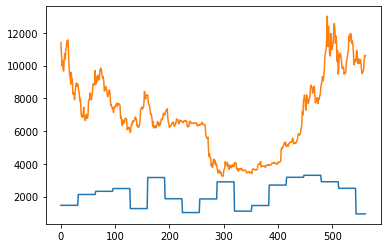

In [18]:
plt.plot(y_pred)
plt.plot(testY)

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
erroEmPorcento = mean_absolute_percentage_error(testY,y_pred)
print(100-erroEmPorcento)
erroEmPorcento

35.038501024246216


64.96149897575378